### Goal ###
Find the nearest [California Data Exchange Center](https://cdec.water.ca.gov/) weather station to each of our California bins. This information will be used to assign each bin weather variable values.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
%matplotlib inline

**Config. variables, to be moved out when notebook becomes finalized script**

In [43]:
# Data files
air_temp_data_file = '../data/CDEC_weather_data/TEMP_1day.csv'
california_bins_file = '../data/spatial_data/california_bins.csv'
target_stations_file = '../data/CDEC_weather_data/target_stations.csv'
empty_noxels_file = '../data/training_data/CDEC_noxels_empty_1day.csv'
output_file = '../data/training_data/CDEC_noxels_TEMP_1day.csv'

# Parallelization options
n_threads = 15

In [44]:
bins = pd.read_csv(california_bins_file)
stations = pd.read_csv(target_stations_file)
stations.columns = ['station','elevation', 'lat', 'long']
stations = stations[stations.long != 0]
bin_array = np.column_stack([bins['long'], bins['lat']])
station_array = np.column_stack([stations['long'], stations['lat']])
bins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4136 entries, 0 to 4135
Data columns (total 2 columns):
long    4136 non-null float64
lat     4136 non-null float64
dtypes: float64(2)
memory usage: 64.8 KB


In [45]:
bins.head()

,long,lat
0,-117.08,32.62
1,-116.98,32.62
2,-116.88,32.62
3,-116.78,32.62
4,-116.68,32.62


In [46]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785 entries, 0 to 785
Data columns (total 4 columns):
station      785 non-null object
elevation    785 non-null int64
lat          785 non-null float64
long         785 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 30.7+ KB


In [47]:
stations.head()

,station,elevation,lat,long
0,CBT,10700,36.563683,-118.347946
1,IWC,4000,35.685000,-117.889400
2,SYC,4800,34.583000,-119.076000
3,TRM,752,36.415000,-119.002000
4,COY,720,39.197000,-123.186000


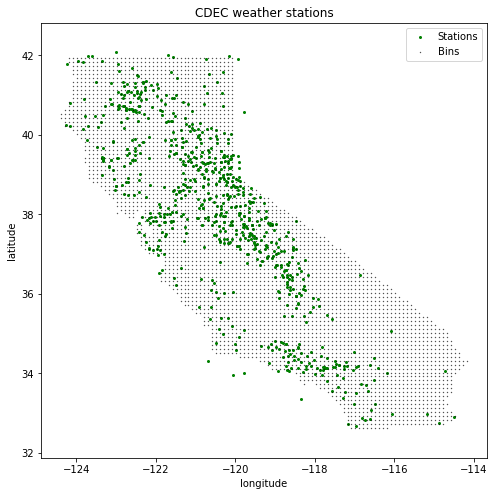

In [48]:
plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(x = stations['long'], y = stations['lat'], color = 'green', s = 4)
plt.scatter(x = bins['long'], y = bins['lat'], color = 'black', s = 0.1)
plt.axis('equal')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('CDEC weather stations')
plt.legend(['Stations', 'Bins'])
plt.show()

Since we have many bins which do not contain a weather monitoring station, the next step is to fill in their values from the nearest station. First find the nearest station to each bin. To do this we will use scipy.spatial.

In [49]:
from scipy import spatial

station_tree = spatial.cKDTree(station_array)
dist, indexes = station_tree.query(bin_array)

nearest_station_names = []
for index in indexes:
    nearest_station_names.append(stations.iloc[index, 0])
    
bins['nearest_station_name'] = nearest_station_names
bins.head()

,long,lat,nearest_station_name
0,-117.08,32.62,SMG
1,-116.98,32.62,SMG
2,-116.88,32.62,SMG
3,-116.78,32.62,SMG
4,-116.68,32.62,API


Now we will make an hourly time series spanning one day in 2015 and assign each bin a temprature from it's nearest station each hour. 

In [51]:
# Annoying, but here goes...
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

temp_data = pd.read_csv(air_temp_data_file, parse_dates = ['OBS_DATE'], usecols = ["STATION_ID", "OBS_DATE", "VALUE"], index_col = "OBS_DATE")
temp_data = temp_data[temp_data.VALUE != '---']
temp_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16291 entries, 2015-01-01 23:00:00 to 2015-01-02 23:00:00
Data columns (total 2 columns):
STATION_ID    16291 non-null object
VALUE         16291 non-null int64
dtypes: int64(1), object(1)
memory usage: 381.8+ KB


In [52]:
temp_data.head()

,STATION_ID,VALUE
OBS_DATE,,
2015-01-01 23:00:00,BCH,9
2015-01-02 00:00:00,BCH,8
2015-01-02 01:00:00,BCH,8
2015-01-02 02:00:00,BCH,7
2015-01-02 03:00:00,BCH,7


Here is an example of a station which does not report regularly on the hour. I am sure there are many other cases of this in the dataset. There are also almost certainly missing values. To fix this, we will resample and interpolate to a regular hourly frequency over the whole dataset.

In [53]:
bud_station = temp_data[temp_data['STATION_ID'] == 'BUD']
bud_station.head()

,STATION_ID,VALUE
OBS_DATE,,
2015-01-01 23:00:00,BUD,33
2015-01-01 23:15:00,BUD,33
2015-01-01 23:30:00,BUD,33
2015-01-01 23:45:00,BUD,33
2015-01-02 00:00:00,BUD,33


In [54]:
bud_station_min = bud_station.resample('min')
bud_station_min = bud_station_min.interpolate(method = 'linear')
bud_station_hr = bud_station_min.resample('H')
bud_station_hr = bud_station_hr.interpolate(method = 'linear')
bud_station_hr['STATION_ID'] = 'BUD'
bud_station_hr.head()

,STATION_ID,VALUE
OBS_DATE,,
2015-01-01 23:00:00,BUD,33.0
2015-01-02 00:00:00,BUD,33.0
2015-01-02 01:00:00,BUD,33.0
2015-01-02 02:00:00,BUD,32.0
2015-01-02 03:00:00,BUD,32.0


To run on the whole dataset we will parallelize the above operation:

In [120]:
def regularize(group):
    group = group.loc[~group.index.duplicated()]  # without this line, get 'ValueError: 
                                                  # cannot reindex from a duplicate axis'
    group = group.resample('min')
    group = group.interpolate(method = 'linear')
    group = group.resample('H')
    group = group.interpolate(method = 'linear')
    return group

def group_data(temp_data_split):
    grouped_data = temp_data_split.groupby('STATION_ID')
    return grouped_data.apply(regularize)
    
def parallelize(temp_data, func, n_cores = n_threads):
    '''Parallelizes regularization, takes temp data and
    splits up regularization fuction over avalibile threads'''
    temp_data_split = np.array_split(temp_data, n_cores)
    pool = Pool(n_cores)
    result = pd.concat(pool.map(func, temp_data_split))
    pool.close()
    pool.join()
    return result
    
%time regularized_temp_data = parallelize(temp_data, group_data)

regularized_temp_data['STATION_ID'] = regularized_temp_data.index.get_level_values(0)
regularized_temp_data = regularized_temp_data.reset_index(level = 0, drop = True)
regularized_temp_data = regularized_temp_data.set_index(['STATION_ID'], append = True)

# Not sure I actualy need any of this stuff but it was in the last working version
#regularized_temp_data['VALUE'].replace('', np.nan, inplace = True) 
#regularized_temp_data.dropna(subset = ['VALUE'], inplace = True)
#regularized_temp_data = regularized_temp_data.loc[~regularized_temp_data.index.duplicated()]

CPU times: user 121 ms, sys: 340 ms, total: 461 ms
Wall time: 12.9 s


Not exactly sure why we actualy end up with less observations after regularization...

In [121]:
regularized_temp_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12112 entries, (2015-01-01 23:00:00, ALD) to (2015-01-02 23:00:00, ZEN)
Data columns (total 1 columns):
VALUE    12109 non-null float64
dtypes: float64(1)
memory usage: 134.2+ KB


In [122]:
regularized_temp_data.head()

,,VALUE
OBS_DATE,STATION_ID,
2015-01-01 23:00:00,ALD,35.0
2015-01-02 00:00:00,ALD,33.0
2015-01-02 01:00:00,ALD,33.0
2015-01-02 02:00:00,ALD,32.0
2015-01-02 03:00:00,ALD,31.0


In [123]:
date_range_start = regularized_temp_data.index.get_level_values(0).min()
date_range_end = regularized_temp_data.index.get_level_values(0).max()

In [124]:
date_range_start

Timestamp('2015-01-01 23:00:00')

In [125]:
date_range_end

Timestamp('2015-01-02 23:00:00')

In [126]:
time_series = pd.date_range(date_range_start, date_range_end, freq = "H").to_series()
time_series

2015-01-01 23:00:00   2015-01-01 23:00:00
2015-01-02 00:00:00   2015-01-02 00:00:00
2015-01-02 01:00:00   2015-01-02 01:00:00
2015-01-02 02:00:00   2015-01-02 02:00:00
2015-01-02 03:00:00   2015-01-02 03:00:00
2015-01-02 04:00:00   2015-01-02 04:00:00
2015-01-02 05:00:00   2015-01-02 05:00:00
2015-01-02 06:00:00   2015-01-02 06:00:00
2015-01-02 07:00:00   2015-01-02 07:00:00
2015-01-02 08:00:00   2015-01-02 08:00:00
2015-01-02 09:00:00   2015-01-02 09:00:00
2015-01-02 10:00:00   2015-01-02 10:00:00
2015-01-02 11:00:00   2015-01-02 11:00:00
2015-01-02 12:00:00   2015-01-02 12:00:00
2015-01-02 13:00:00   2015-01-02 13:00:00
2015-01-02 14:00:00   2015-01-02 14:00:00
2015-01-02 15:00:00   2015-01-02 15:00:00
2015-01-02 16:00:00   2015-01-02 16:00:00
2015-01-02 17:00:00   2015-01-02 17:00:00
2015-01-02 18:00:00   2015-01-02 18:00:00
2015-01-02 19:00:00   2015-01-02 19:00:00
2015-01-02 20:00:00   2015-01-02 20:00:00
2015-01-02 21:00:00   2015-01-02 21:00:00
2015-01-02 22:00:00   2015-01-02 2

Now we make a dataframe of 'noxels' or n-dimentional voxels. Each row will be a bin at a specific time. Once we have this dataframe, we can go back though and assign weather variable values to each noxel.

In [127]:
def apply_to_bins(time_series, bins):
    return bins.assign(time = time_series)

%time noxels = pd.concat(time_series.apply(apply_to_bins, args = (bins,)).tolist())
noxels.to_csv(empty_noxels_file, index = False)

CPU times: user 78.5 ms, sys: 12.2 ms, total: 90.6 ms
Wall time: 84.7 ms


In [128]:
noxels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103400 entries, 0 to 4135
Data columns (total 4 columns):
long                    103400 non-null float64
lat                     103400 non-null float64
nearest_station_name    103400 non-null object
time                    103400 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 3.9+ MB


In [129]:
noxels.head()

,long,lat,nearest_station_name,time
0,-117.08,32.62,SMG,2015-01-01 23:00:00
1,-116.98,32.62,SMG,2015-01-01 23:00:00
2,-116.88,32.62,SMG,2015-01-01 23:00:00
3,-116.78,32.62,SMG,2015-01-01 23:00:00
4,-116.68,32.62,API,2015-01-01 23:00:00


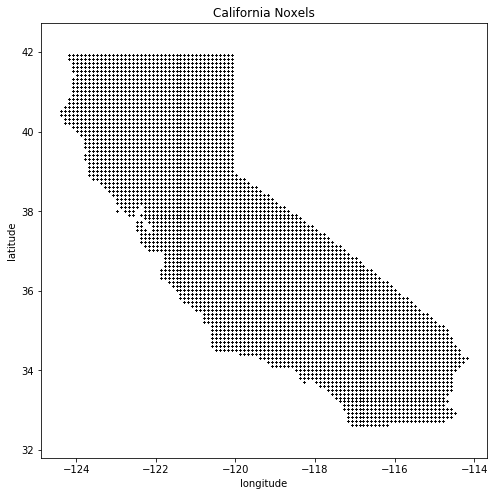

In [130]:
plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(x = empty_noxels['long'], y = empty_noxels['lat'], color = 'black', s = 0.1)
plt.axis('equal')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('California Noxels')
plt.show()

In [133]:
regularized_temp_data.at[('2015-01-01 23:00:00', 'ACN'), 'VALUE']

31.0

Add temperature data to noxels

In [144]:
def try_except(row):
    try:
        return regularized_temp_data.at[(row['time'], row['nearest_station_name']), 'VALUE']
    except:
        return np.nan
    
def add_data(noxels):
    noxels['temp'] = noxels.apply(lambda row: try_except(row), axis = 1)
    return noxels

def parallelize(noxels, func, n_cores = n_threads):
    '''Parallelizes downsampling, takes list of stations and
    splits up the downsampling fuction over avalibile threads'''
    noxels_split = np.array_split(noxels, n_cores)
    pool = Pool(n_cores)
    result = pd.concat(pool.map(func, noxels_split))
    pool.close()
    pool.join()
    return result

%time noxels = parallelize(noxels, add_data)

noxels = noxels.dropna()
noxels.to_csv(output_file, index = False)

CPU times: user 756 ms, sys: 530 ms, total: 1.29 s
Wall time: 2.68 s


In [145]:
noxels.head()

,long,lat,nearest_station_name,time,temp
0,-117.08,32.62,SMG,2015-01-01 23:00:00,44
1,-116.98,32.62,SMG,2015-01-01 23:00:00,44
2,-116.88,32.62,SMG,2015-01-01 23:00:00,44
3,-116.78,32.62,SMG,2015-01-01 23:00:00,44
4,-116.68,32.62,API,2015-01-01 23:00:00,34


In [146]:
noxels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71227 entries, 0 to 4135
Data columns (total 5 columns):
long                    71227 non-null float64
lat                     71227 non-null float64
nearest_station_name    71227 non-null object
time                    71227 non-null datetime64[ns]
temp                    71227 non-null object
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 3.3+ MB


OK, so, working to a first approximation. Lets check some lengths and see how we did. If we filled every bin with a temperature value, then we should have (n bins *  n time_series) rows in our data file...

In [147]:
(len(noxels) / (len(bins) * len(time_series))) * 100

68.88491295938104

Ok, so there is an issue here. By building the bin array and finding the nearest station first, we are causing empty bins. If for a given time slices, a bin's nearest station did not report data, we have no fallback and end up leaving that bin empty. This appears to happen >30% of the time. Not great.

In [148]:
noxels_one_hour = noxels[noxels['time'] == '2015-01-01 23:00:00']

In [149]:
noxels_one_hour.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2846 entries, 0 to 4135
Data columns (total 5 columns):
long                    2846 non-null float64
lat                     2846 non-null float64
nearest_station_name    2846 non-null object
time                    2846 non-null datetime64[ns]
temp                    2846 non-null object
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 133.4+ KB


In [150]:
noxels_one_hour.head()

,long,lat,nearest_station_name,time,temp
0,-117.08,32.62,SMG,2015-01-01 23:00:00,44
1,-116.98,32.62,SMG,2015-01-01 23:00:00,44
2,-116.88,32.62,SMG,2015-01-01 23:00:00,44
3,-116.78,32.62,SMG,2015-01-01 23:00:00,44
4,-116.68,32.62,API,2015-01-01 23:00:00,34


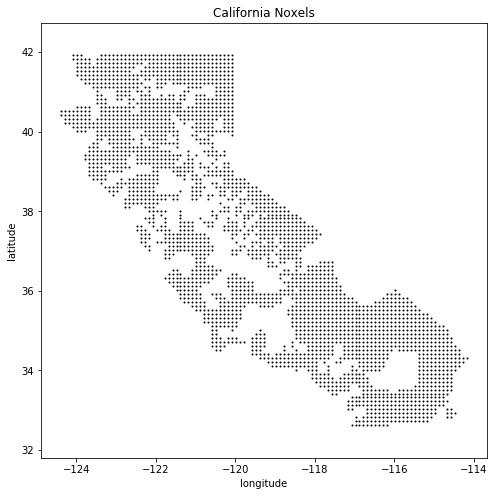

In [151]:
plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(x = noxels_one_hour['long'], y = noxels_one_hour['lat'], color = 'black', s = 1)
plt.axis('equal')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('California Noxels')
plt.show()

Note: the empty areas are bins for which the nearest station did not report data during this time slice.